In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
from collections import defaultdict
import os

In [34]:
file_paths_list = []
parent = None
if 'lunar_analog_spectra' not in os.listdir(os.getcwd()):
    print(f'lunar_analog_spectra folder not found')
else:
    parent = os.path.join(os.getcwd(), 'lunar_analog_spectra')
    for folder_name in os.listdir(parent):
        if folder_name[-9:] == ".DS_Store": continue
        folder_path = os.path.join(parent, folder_name)
        for file in os.listdir(folder_path):
            if file[-4:] == '.csv':
                file_path = os.path.join(folder_path, file)
                file_paths_list.append(file_path)

print(f"# of file paths: {len(file_paths_list)}")

# of file paths: 26


In [35]:
# assumed step size between m3 points
STEPSIZE = 0.04

# boundaries for wavelengths, outside of which to ignore/truncate data
WL_MIN = 0.46
WL_MAX = 2.94

# TODO (in order of priority)
# !save binned xy pairs and cubic spline xy pairs to CSVs
# convert to python script file to run from cli
# modify to read in a folder of csvs and a target to bin to (m3 in original case)
# use variable (0.02 vs 0.04) step size based on micron range
# rename + recolor graph legend
# save graphs into subfolders based on lunar_analog_spectra folders (Iceland_JB501C graph goes into /Glass_volcanics)
# prompt user whether to save graphs

# step size until 1.57 microns
# STEPSIZE_PRE = 0.02
# step size after 1.57 microns 
# STEPSIZE_POST = 0.04

In [36]:
# boundaries: 
# m^3
# 0.46 microns - 460 nanometers
# 3 microns  - 3000 nanometers
# trailblazer
# 0.6 microns - 600 nanometers
# 3.6 microns - 3600 nanometers

# bin methods
# 1:1, cubic spline over 84 points (check for uniform step size)

In [37]:
m3 = pd.read_csv('m3 original data.csv')
# lab = pd.read_csv('lunar_analog_spectra/Pyroxene lab spectra FDL/USGS augite WS592.csv')
# lab = pd.read_csv('lunar_analog_spectra/Pyroxene lab spectra FDL/USGS orthoclase spliced.csv')
# lab = pd.read_csv('lunar_analog_spectra/Glass_volcanics/Iceland_JB501C.csv')
lab = pd.read_csv('lunar_analog_spectra/Glass_volcanics/Mauna Iki_basaltic_glass_JB388A_spliced.csv')

In [38]:
# m3.head()

In [39]:
x_m3 = (m3['Wavelength (µm)']).tolist()
x_m3 = [f"{wl:.5f}" for wl in x_m3]
print(f"# of m^3 wavelengths: {len(x_m3)}, first and last: {x_m3[0], x_m3[-1]}")

# of m^3 wavelengths: 84, first and last: ('0.46099', '2.93630')


In [40]:
# lab.head()

In [52]:
lab['Wavelength (µm)'] = lab['Wavelength (nm)']/1000
lab = lab.set_index('Wavelength (µm)')
lab.columns = lab.columns.str.replace(",","")

y_column_label = lab.columns[1]
x_raw = list(lab.index)
y_raw = list(lab[y_column_label])

print(f"first and last raw x,y pairs\n{(x_raw[0], y_raw[0])}\n{(x_raw[-1], y_raw[-1])}")
# y_column_label

'Mauna Iki HI basaltic glass JB388A <125 ¬µm'

In [42]:
# bins stored as numerical strings
binned_raw = defaultdict(list)
for x in x_m3:
    binned_raw[x] = []
len(binned_raw)

84

In [43]:
# append points to bin with wavelength within half of stepsize
# average points across list
# precondition: wavelengths are sorted in ascending order

binCounter = 0
for x,y in zip(x_raw, y_raw):
    if x < WL_MIN or x > WL_MAX: continue

    lbound = float(x_m3[binCounter]) - STEPSIZE/2
    rbound = float(x_m3[binCounter]) + STEPSIZE/2

    # while point doesn't fit into current bin
    # increment binCounter unless not found
    while x > rbound: 
        if binCounter + 1 < len(x_m3):
            binCounter += 1

            # update bin bounds
            lbound = float(x_m3[binCounter]) - STEPSIZE/2
            rbound = float(x_m3[binCounter]) + STEPSIZE/2
        else:
            print(f"Point {x, y} within WL MINMAX range {WL_MIN, WL_MAX} but no bin found, last {lbound, rbound}")
            break
    
    # add point to bin
    binned_raw[x_m3[binCounter]].append((x,y))
    
print(f"bin index: {binCounter}, input list size: {len(x_raw)}")

bin index: 83, input list size: 2560


In [44]:
# average all wavelength values in the same bin

y_avg = []
x_avg = []
for count, bin in enumerate(binned_raw):
    if len(binned_raw[bin]) == 0:
        x_avg.append(bin)
        y_avg.append(-1)
        print(f"Empty bin at {bin}")
        continue

    # average over all raw reflectance values
    avgx = 0
    avgy = 0
    for x,y in binned_raw[bin]:
        avgx += x
        avgy += y
    avgx /= len(binned_raw[bin])
    avgy /= len(binned_raw[bin])

    y_avg.append(avgy)
    x_avg.append(avgx)

print(f"# of average reflectance values {len(y_avg)}, first and last averaged points {[(x_avg[0], y_avg[0]), (x_avg[-1], y_avg[-1])]}")

# of average reflectance values 84, first and last averaged points [(0.47000000000000003, 0.0773906), (2.928914285714286, 0.14800714285714286)]


In [45]:
from scipy.interpolate import CubicSpline

spline_points = len(x_avg)
cs_avg = CubicSpline(x_avg, y_avg)

x_spline_avg = list(np.linspace(min(x_avg), max(x_avg), spline_points))
y_spline_avg = list(cs_avg(x_spline_avg))

# len(x_spline_avg), len(y_spline_avg)

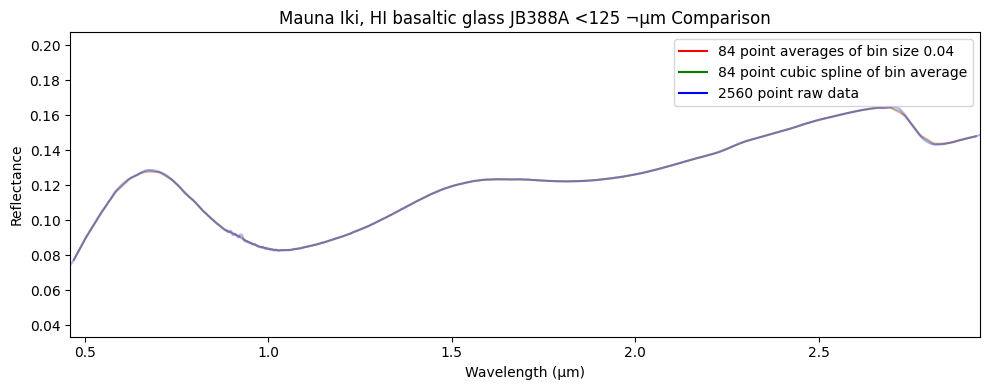

In [46]:
plot.rcParams['figure.figsize'] = (10,4)

ax = sns.lineplot(
    x = x_avg,
    y = y_avg,
    label = f"{len(x_avg)} point averages of bin size 0.04",
    color = "red",
)

ax = sns.lineplot(
    x = x_spline_avg,
    y = y_spline_avg,
    label = f"{spline_points} point cubic spline of bin average",
    color = "green",
)

ax = sns.lineplot(
    x = x_raw,
    y = y_raw,
    label = f"{len(x_raw)} point raw data",
    color = 'blue',
)

for line in ax.lines:
    line.set_alpha(0.3)


plot.title(f"{y_column_label} Comparison")
plot.xlabel('Wavelength (µm)')
plot.ylabel('Reflectance')

plot.xlim(WL_MIN, WL_MAX)
plot.tight_layout()
# plot.savefig(f'graphs/{y_column_label} Comparison.png', bbox_inches='tight', dpi = 1000, transparent = False)
plot.show()

In [47]:
while len(x_raw) != len(x_avg) or len(x_raw) != len(x_spline_avg):
    x_avg.append('')
    y_avg.append('')
    x_spline_avg.append('')
    y_spline_avg.append('')

In [48]:
def writeFile(path, mode): # x = new, w = overwrite
    output = open(path, mode)
    output.write(f"Wavelength raw,{y_column_label} raw,Wavelength bin avg,{y_column_label} bin avg,Wavelength cubic spline of bin avg,{y_column_label} cubic spline of bin avg\n")

    # ends when shortest zip input runs out
    for xr, yr, xavg, yavg, xspline, yspline in zip(x_raw, y_raw, x_avg, y_avg, x_spline_avg, y_spline_avg):
        output.write(f"{xr},{yr},{xavg},{yavg},{xspline},{yspline}\n")
    output.close()

In [49]:
output_path = file_paths_list[0].replace('/lunar_analog_spectra/', '/csv output/')

try: 
    writeFile(output_path, 'x')
except:
    # writeFile(output_path,'w')
    print('file present')
    pass

file present
